# Eager Execution


### Graphs

- Advantages
    - Optimizable
    - Deployable
    - Rewritable
    
    
- Disadvantages
    - Difficult to debug
    - Un-pythonic
    
**Eager Execution** - A NumPy like library for numerical computation with support for GPU acceleration and automatic differentiation, and a flexible platform for machine learning research and experimentation.

- Advantages
    - Compatible with Python debugging tools (`pdb`)
    - Provides immediate error reporting
    - Permits use of Python Data Structures
    - Enables easy, Pythonic control flow
    - No longer need to worry about `placeholders`, `sessions`, `control dependencies`, `"lazy loading"`, `{name, variable, op} scopes`

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

In [3]:
# Graph-based
x = tf.placeholder(tf.float32, shape=[1, 1])
m = tf.matmul(x, x)
print(m)

with tf.Session() as sess:
    m_out = sess.run(m, feed_dict={x: [[2.0]]})
print(m_out)

Tensor("MatMul_1:0", shape=(1, 1), dtype=float32)
[[4.]]


In [4]:
# Lazy Loading
x = tf.random_uniform([2, 2])

with tf.Session() as sess:
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            print(sess.run(x[i, j]))  # Each iteration adds nodes to the graph

0.89362836
0.18055153
0.22100377
0.17774534


#### Eager Execution

In [3]:
x = [[2.0]]  # No placeholder
m = tf.matmul(x, x)
print(m)  # No session

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


In [4]:
# Lazy loading
x = tf.random_uniform([2, 2])

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i, j])

tf.Tensor(0.75011075, shape=(), dtype=float32)
tf.Tensor(0.25964546, shape=(), dtype=float32)
tf.Tensor(0.5588856, shape=(), dtype=float32)
tf.Tensor(0.5911846, shape=(), dtype=float32)


In [2]:
# Tensors act like NumPy arrays
x = tf.constant([1.0, 2.0, 3.0])

assert type(x.numpy()) == np.ndarray
squared = np.square(x)  # Tensors are compatible with NumPy functions

for i in x:  # Tensors are iterable
    print(i)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)


**Gradients** - Automatic differentiation is built into eager execution

[Automatic Differentiation](https://arxiv.org/pdf/1502.05767.pdf)

In [3]:
def square(x):
    return x**2

grad = tfe.gradients_function(square)  # Differentiate w.r.t. input of squae

print('square: ', square(3.0))
print('grad: ', grad(3.0))

square:  9.0
grad:  [<tf.Tensor: id=32, shape=(), dtype=float32, numpy=6.0>]


### [User Guide](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/docs_src/programmers_guide/eager.md)

- Use `tfe.Variable` when eager execution is enabled
- API's for computing gradients work *even when eager execution is not enabled*
    - `tfe.gradients_function()`
    - `tfe.value_and_gradients_function()`
    - `tfe.implicit_gradients()`
    - `tfe.implicit_value_and_gradients()`

In [4]:
x = tfe.Variable(2.0)

def loss(y):
    return (y - x**2)**2

grad = tfe.implicit_gradients(loss)  # Differentiate w.r.t. variables used to compute loss

print('loss: ', loss(7))
print('grad: ', grad(7))

loss:  tf.Tensor(9.0, shape=(), dtype=float32)
grad:  [(<tf.Tensor: id=90, shape=(), dtype=float32, numpy=-24.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>)]


When **eager** execution is enabled

- Prefer `tfe.Variable`
- Use `tfe.Iterator`
- Prefer Object Oriented layers (e.g. `tf.layers.Dense`)

# Linear Regression *(Huber loss)* with Eager Execution

In [17]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Utility function
def read_birth_life_data(filename):
    """
    Read in birth_life_2010.txt and return:
    data in the form of NumPy array
    n_samples: number of samples
    """
    text = open(filename, 'r').readlines()[1:]
    data = [line[:-1].split('\t') for line in text]
    births = [float(line[1]) for line in data]
    lifes = [float(line[2]) for line in data]
    data = list(zip(births, lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

In [27]:
# Read the data into a dataset
DATA_FILE = 'data/birth_life_2010.txt'

data, n_samples = read_birth_life_data(DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [28]:
# Create weight and bias variables, initialized to 0.0
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

In [20]:
# Define linear predictor
def prediction(x):
    return tf.add(tf.multiply(w, x), b)

In [29]:
# Define loss function: single example so no tf.reduce_sum
def squared_loss(y, y_predicted):
    return tf.square(tf.subtract(y, y_predicted))

**Huber Loss** - Robust to outliers. 

Intuition - If the difference between the predicted value and the real value is small, then square the it, if the difference is large, then take its absolute value

$$L_{\delta}(y, f(x)) = \begin{cases}
                          \frac{1}{2}(y-f(x))^2 & \text{for}\ \left|y-f(x)\right| \leq \delta \\
                          \delta\left|y-f(x)\right| - \frac{1}{2}\delta^2 & \text{otherwise}
                        \end{cases}$$

In [38]:
# Define Huber loss
def huber_loss(y, y_predicted, m=1.0):
    if abs(y - y_predicted) <= m:
        return 0.5 * squared_loss(y, y_predicted)
    else:
        return m * abs(y - y_predicted) - 0.5 * m**2

In [41]:
# Define train function
def train(loss_fn):
    """Train a regression model evaluated using `loss_fn`"""
    print('Training; Loss function: ', loss_fn.__name__)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

    # Define the function through which to differentiate
    def loss_for_example(x, y):
        return loss_fn(y, prediction(x))
    
    # Obtain a gradients function using `tfe.implicit_value_and_gradients`
    grad_fn = tfe.implicit_value_and_gradients(loss_for_example)
    
    # Train
    num_epochs = 100
    start = time.time()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_i, y_i in tfe.Iterator(dataset):
            loss, gradients = grad_fn(x_i, y_i)
            
            # Take an optimization step and update variables
            optimizer.apply_gradients(gradients)
            
            total_loss += loss
        if epoch % 10 == 0:
            print('Epoch {}: {}'.format(epoch, total_loss/n_samples))
    print('Took: {:0.2f}'.format(time.time() - start))

Training; Loss function:  huber_loss
Epoch 0: 4.5785112380981445
Epoch 10: 3.9183990955352783
Epoch 20: 3.764439582824707
Epoch 30: 3.718583822250366
Epoch 40: 3.7050487995147705
Epoch 50: 3.700268030166626
Epoch 60: 3.6995301246643066
Epoch 70: 3.6999752521514893
Epoch 80: 3.7005624771118164
Epoch 90: 3.7010445594787598
Took: 20.70


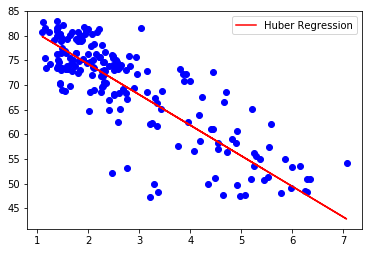

In [67]:
# Training
train(huber_loss)

# Plot
plt.plot(data[:,0], data[:,1], 'bo')
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), 'r', 
         label='Huber Regression')
plt.legend()
plt.show()

# Scratch

In [65]:
def sq_loss_for_example(x, y):
    return squared_loss(y, prediction(x))

def huber_loss_for_example(x, y):
    return huber_loss(y, prediction(x))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
grad_fn = tfe.implicit_value_and_gradients(sq_loss_for_example)
x, y = tfe.Iterator(dataset).next()
print('x: ', x)
print('y: ', y)
loss, grad = grad_fn(x, y)
print('loss: ', loss)
print('grad: ', grad)

x:  tf.Tensor(1.822, shape=(), dtype=float32)
y:  tf.Tensor(74.82825, shape=(), dtype=float32)
loss:  tf.Tensor(44.29114, shape=(), dtype=float32)
grad:  [(<tf.Tensor: id=2356136, shape=(), dtype=float32, numpy=-24.2514>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-2.0677629>), (<tf.Tensor: id=2356135, shape=(), dtype=float32, numpy=-13.310318>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=71.94055>)]
